<a href="https://colab.research.google.com/github/kd303/trnsfrmr_pytrch_end_p1/blob/main/session_07_hyperparams/assignment/session_7_evaluation_score_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline  

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [ ]:
!wget https://download.pytorch.org/tutorial/data.zip

!unzip data.zip

--2021-12-03 18:28:00--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 52.85.79.74, 52.85.79.72, 52.85.79.49, ...
Connecting to download.pytorch.org (download.pytorch.org)|52.85.79.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip.1’

data.zip.1          100%[===================>]   2.75M  5.77MB/s    in 0.5s    

2021-12-03 18:28:01 (5.77 MB/s) - ‘data.zip.1’ saved [2882130/2882130]

Archive:  data.zip
replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/names/Arabic.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['je prepare le the .', 'i m making tea .']


In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output, hidden = self.gru(output, hidden)
        output = F.relu(output)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [ ]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
import math

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg, math.exp(print_loss_avg)))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

**BLEU (BiLingual Evaluation Understudy)** is a metric for automatically evaluating machine-translated text. The BLEU score is a number between zero and one that measures the similarity of the machine-translated text to a set of high quality reference translations. A value of 0 means that the machine-translated output has no overlap with the reference translation (low quality) while a value of 1 means there is perfect overlap with the reference translations (high quality).

It has been shown that BLEU scores correlate well with human judgment of translation quality. Note that even human translators do not achieve a perfect score of 1.0.

BLEU Score |	Interpretation
---|---
< 10    |	Almost useless
10 - 19 |	Hard to get the gist
20 - 29	|The gist is clear, but has significant grammatical errors
30 - 40	| Understandable to good translations
40 - 50	| High quality translations
50 - 60	| Very high quality, adequate, and fluent translations
60	| Quality often better than human

**Following is the scale**

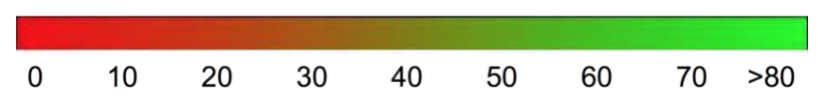

In [38]:
from torchtext.data.metrics import bleu_score
def evaluate_bleu_score(encoder, decoder, n=10, score_type ='BLEU'):
    ref_d = []
    pred_d = []
    score = -1
    for i in range(n):
        pair = random.choice(pairs)
        # print('Original ', pair[0])
        
        ref_d.append(pair[1].strip().split(' '))
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        pred_d.append(output_words[:-1])
        output_sentence = ' '.join(output_words[:-1])
        print('Translated (truth): ', pair[1])
        print('Translated (pred): ' , output_sentence)
        print('')
    if(score_type == 'BLEU'):
      
      # score = bleu_score(candidate_corpus, references_corpus=references_corpus, max_n=4, weights=[0.25,0.25,0.25,0.25])
      score = bleu_score(candidate_corpus, references_corpus=references_corpus, max_n=1, weights=[1])
    print(score)

In [ ]:
from torchtext.data.metrics import bleu_score
candidate_corpus = [['you', 're', 'so', 'predictable', '.'], ['i', 'm', 'sad', 'without', 'you', '.']]
references_corpus =[[['you', 're', 'so', '!', '!'], ['Completely', 'Different']], [['My', 'full', 'pytorch', 'test', 'lapuza']]]
bleu_score(candidate_corpus, references_corpus=references_corpus, max_n=2, weights=[0.20, 0.80])

0.2315131574869156

In [32]:
from torchtext.data.metrics import bleu_score
# n_grams are kept at 2, instead of default 4
def cal_bleu_score(ground_truth, predicted_wrds):
  # both are arrays and not sentences
  print(ground_truth, predicted_wrds)
  g_trth = []
  p_wrds = []
  g_trth.append(ground_truth)
  p_wrds.append(predicted_wrds[:-1])
  # print('len_grd_trt ',len(ground_truth), 'predicted_wrds :  ', len(predicted_wrds), ' type : ', type(predicted_wrds))
  return bleu_score(g_trth,p_wrds, max_n=1, weights=[1])


In [ ]:
cal_bleu_score

In [39]:
score_b = evaluate_bleu_score(encoder1, attn_decoder1, n=20)

score_b

Translated (truth):  i m not signing anything .
Translated (pred):  i i i i i i i i i

Translated (truth):  we re both right .
Translated (pred):  we we we we we we we we we

Translated (truth):  i m getting hungry .
Translated (pred):  i i i i i i i i i

Translated (truth):  i m not sure about that .
Translated (pred):  we we we we we we we we we

Translated (truth):  you re out of booze .
Translated (pred):  he s he s he s he s he

Translated (truth):  i m proud of my children .
Translated (pred):  i i i i i i i i i

Translated (truth):  you re too skinny .
Translated (pred):  you you you you you you you you you

Translated (truth):  we re blood brothers .
Translated (pred):  we we we we we we we we we

Translated (truth):  i m not sleepy .
Translated (pred):  i i i i i i i i i

Translated (truth):  i m sorry if i frightened you .
Translated (pred):  i i i i i i i i i

Translated (truth):  i m not telling you again .
Translated (pred):  we we we we we we we we we

Translated (truth):

In [ ]:
from bert_score import score

def cal_bert_score(ground_truth, predicted_wrds):
  P, R, F1 = score(predicted_wrds, ground_truth, lang="en", verbose=True)
  return F1


2m 1s (- 8m 7s) (5000 20%) 2.9487 19.0815
4m 1s (- 6m 2s) (10000 40%) 2.4837 11.9859
6m 0s (- 4m 0s) (15000 60%) 2.2778 9.7552
8m 1s (- 2m 0s) (20000 80%) 2.1242 8.3661
10m 2s (- 0m 0s) (25000 100%) 1.9739 7.1990


<Figure size 432x288 with 0 Axes>

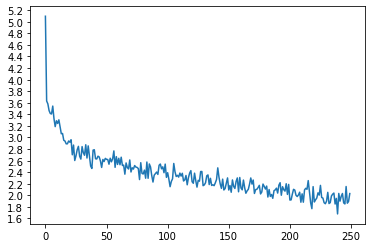

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
# 75000 - just for testing the scores
trainIters(encoder1, attn_decoder1, 25000, print_every=5000)

## prints (time) (epoch %epochs complete) loss PPL(exp(loss))

## Perplexity(PPL)

*   Above Training iteration prints the ```exp(log_loss)``` is getting printed at every 5000th iteration.

*   We should note that the metric applies specifically to classical language models (sometimes called autoregressive or causal language models) and is not well defined for masked language models like BERT.

*   Also, for translation it is not evaluation, it just indicates how well a sentence is formed 


*   Perplexity is a measurement of how well a probability distribution or probability model predicts a sample. It may be used to compare probability models. A low perplexity indicates the probability distribution is good at predicting the sample.

*   In natural language processing, perplexity is a way of evaluating language models. A language model is a probability distribution over entire sentences or texts


From : https://huggingface.co/docs/transformers/perplexity

Equation

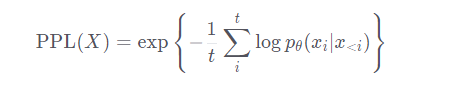


**where log function is the log-likelyhood of ith token conditioned on the preceding tokens.. below is the Visual representation**

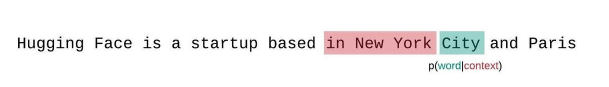

In [ ]:
!pip install transformers==3.0.1
!pip install bert_score==0.3.4

## BERT Score
BERTScore leverages the pre-trained contextual embeddings from BERT and matches words in candidate and reference sentences by cosine similarity. It has been shown to correlate with human judgment on sentence-level and system-level evaluation. Moreover, BERTScore computes precision, recall, and F1 measure, which can be useful for evaluating different language generation tasks

In [40]:
from bert_score import score
def evaluate_bert_score(encoder, decoder, n=30):
    ref_d = []
    pred_d = []
    score = -1
    for i in range(n):
        pair = random.choice(pairs)
        # print('Original ', pair[0])
        
        # ref_d.append(pair[1].strip().split(' '))
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        # pred_d.append(output_words[:-1])
        output_sentence = ' '.join(output_words[:-1])
        ref_d.append(pair[1].strip())
        pred_d.append(output_sentence)
        # print('Translated (truth): ', pair[1])
        # print('Translated (pred): ' , output_sentence)
        print('')
    print(ref_d[0])
    return ref_d, pred_d

In [48]:
ref_d, pred_d = evaluate_bert_score(encoder1, attn_decoder1, n=30) 
pred_d































they re dragging their heels .


['you you you you you you you you you',
 'she s she s she s she s she',
 '',
 'we we we we we we we we we',
 'you you you you you you you you you',
 'he s he s he s he s he',
 'm m m m m m m m m',
 'you you you you you you you you you',
 'i i i i i i i i i',
 'i i i i i i i i i',
 'you you you you you you you you you',
 'we we we we we we we we we',
 'he he s he s he s he s',
 'you you you you you you you you you',
 'you you you you you you you you you',
 'i i i i i i i i i',
 'we we we we we we we we we',
 'you you you you you you you you you',
 'm m m m m m m m m',
 'we we we we we we we we we',
 'i i i i i i i i i',
 'we we we we we we we we we',
 'you you you you you you you you you',
 'i i i i i i i i i',
 're we re we re we re we re',
 'not .',
 'you you you you you you you you you',
 'we we we we we we we we we',
 'we we we we we we we we we',
 're you re you re you re you re']

In [43]:
P, R, F1 = score(ref_d, pred_d, lang="en", device=device, verbose=True)

Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.52 seconds, 57.26 sentences/sec


In [46]:
P, R, F1 , P.mean().item(), R.mean().item(), F1.mean().item()

(tensor([0.8241, 0.8008, 0.8118, 0.8094, 0.8173, 0.8402, 0.7852, 0.8336, 0.8435,
         0.8424, 0.8159, 0.8200, 0.8134, 0.8202, 0.8253, 0.8239, 0.8125, 0.7973,
         0.8298, 0.8139, 0.8074, 0.8159, 0.7920, 0.8616, 0.8208, 0.8167, 0.8240,
         0.8062, 0.8278, 0.7671]),
 tensor([0.7624, 0.7605, 0.0000, 0.7764, 0.7833, 0.7261, 0.7617, 0.8072, 0.7409,
         0.7395, 0.7836, 0.7429, 0.7780, 0.7664, 0.7975, 0.7614, 0.7322, 0.7220,
         0.7500, 0.7444, 0.7621, 0.7457, 0.7413, 0.7245, 0.7410, 0.7973, 0.7377,
         0.7310, 0.7609, 0.6966]),
 tensor([0.7920, 0.7802, 0.0000, 0.7926, 0.8000, 0.7790, 0.7733, 0.8202, 0.7889,
         0.7876, 0.7995, 0.7795, 0.7953, 0.7924, 0.8111, 0.7914, 0.7703, 0.7578,
         0.7879, 0.7776, 0.7841, 0.7792, 0.7658, 0.7871, 0.7788, 0.8069, 0.7785,
         0.7668, 0.7929, 0.7301]),
 0.8173344135284424,
 0.7291461825370789,
 0.7582226395606995)

In [ ]:
F1, F1.mean().item()

(tensor([0.9183, 0.8330, 0.9322, 0.8791, 0.8899, 0.8894, 0.9106, 0.9615, 0.8886,
         0.8510, 0.9111, 0.9226, 0.8796, 0.8445, 0.8828, 0.9175, 0.8497, 0.8322,
         0.9390, 0.9633]), 0.8947895169258118)

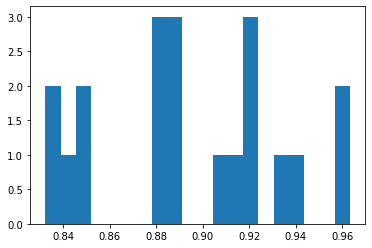

In [ ]:
import matplotlib.pyplot as plt
plt.hist(F1, bins=20)
plt.show()

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

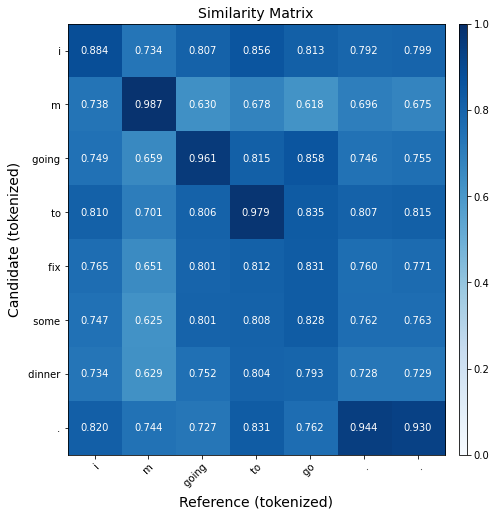

In [ ]:
from bert_score import plot_example

from bert_score import plot_example

r = ref_d[0] 
p = pred_d[0] 
plot_example(r, p, lang="en")

In [ ]:
from tqdm import tqdm

max_length = model.config.n_positions
stride = 512

nlls = []
for i in tqdm(range(0, encodings.input_ids.size(1), stride)):
    begin_loc = max(i + stride - max_length, 0)
    end_loc = min(i + stride, encodings.input_ids.size(1))
    trg_len = end_loc - i    # may be different from stride on last loop
    input_ids = encodings.input_ids[:,begin_loc:end_loc].to(device)
    target_ids = input_ids.clone()
    target_ids[:,:-trg_len] = -100

    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)
        neg_log_likelihood = outputs[0] * trg_len

    nlls.append(neg_log_likelihood)

ppl = torch.exp(torch.stack(nlls).sum() / end_loc)

In [ ]:
def evaluate_bert_score(encoder, decoder, n=10):
    ref_d = []
    pred_d = []
    score = -1
    for i in range(n):
        pair = random.choice(pairs)
        # print('Original ', pair[0])
        
        # ref_d.append(pair[1].strip().split(' '))
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        # pred_d.append(output_words[:-1])
        output_sentence = ' '.join(output_words[:-1])
        ref_d.append(pair[1].strip())
        pred_d.append(output_sentence)
        # print('Translated (truth): ', pair[1])
        # print('Translated (pred): ' , output_sentence)
        print('')
    print(ref_d[0])
    return ref_d, pred_d